# Creating oxidation states lists

We have data-mined a list of oxidation states based on the structures reported in the Inoragnic Crystal Structure Database (as of Sep 2024). This tutorial demonstrates how SMACT can be used to filter this pre-compiled list to produce lists of oxidation states that can be used in SMACT workflows.

## 1. Getting started



[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/WMD-group/SMACT/blob/master/docs/tutorials/filtering_icsd_oxidation_states.ipynb)

In [ ]:
# Install the required packages
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    !pip install "smact[strict] @ git+https://github.com/WMD-group/SMACT.git@master" --quiet

!pip install pandarallel "matplotlib-venn[shapely]" --quiet


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from smact.utils.oxidation import ICSD24OxStatesFilter
from smact.structure_prediction.utilities import parse_spec
import seaborn as sns
import matplotlib.pyplot as plt
import dash
import plotly.graph_objects as go
import plotly.io as pio
from dash.dependencies import Input, Output
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pymatviz as pmv
from matplotlib_venn import venn3
import smact
from smact.utils.composition import comp_maker
from smact.screening import smact_filter, smact_validity
from mp_api.client import MPRester
import pandas as pd
from pandarallel import pandarallel
from pprint import pprint
# Interactive plotly figures don't show up on GitHub.
# https://github.com/plotly/plotly.py/issues/931
# change renderer from "svg" to "notebook" to get hover tooltips back
# (but blank plots on GitHub!)
pio.renderers.default = "png"
sns.set_theme(context="notebook", style="ticks", palette="colorblind")

## 2. Using the oxidation states filter

In [ ]:
# Initialise the oxidation state filter
ox_filter = ICSD24OxStatesFilter()
ox_states_df = ox_filter.ox_states_df
ox_states_df.head(15)

,element,oxidation_state,results_count
0,H,-9,0
1,H,-8,0
2,H,-7,0
3,H,-6,0
4,H,-5,0
5,H,-4,0
6,H,-3,0
7,H,-2,0
8,H,-1,3442
9,H,0,2738


The above code output presents a Dataframe of the occurrences of elements in particular oxidation states mined from the ICSD in September 2024. Here the results count refers to the number of structures in the ICSD that contain the element in a given oxidation state. The mininig process was quite simple, as such there are many 0 values in the table. We can use the built-in method `get_species_occurrences_df` to return a dataframe of the ionic species and the number of occurrences of each species in the ICSD. 

In [ ]:
# Return the dataframe with non-zero results
ox_filter.get_species_occurrences_df(sort_by_occurrences=False)

,species,results_count
0,H-,3442
1,H+,34232
2,H2+,2
3,H3+,1
4,Li+,10513
...,...,...
485,Cf3+,17
486,Cf4+,1
487,Cf5+,1
488,Cf6+,1


In [ ]:
# We can also return the dataframe sorted by occurrences
ox_filter.get_species_occurrences_df(sort_by_occurrences=True)

,species,results_count
0,O2-,116910
1,H+,34232
2,Si4+,18248
3,Na+,17539
4,Ca2+,16605
...,...,...
485,Nd+,1
486,Ca-,1
487,Eu+,1
488,Eu5+,1


To directly produce a list of oxidation states that can be used in SMACT workflows, we have built in functions which can be used to filter the data. The method `filter` can be used to filter the data based on the number of occurrences of the oxidation state in the ICSD. The function takes the following arguments:

- `threshold`: The minimum number of occurrences os structures which contain an element in a particular oxidation state in the ICSD.
- `include_zero`: A boolean value which determines whether to include the neutral oxidation state (0) in the list of oxidation states.

In [ ]:
# Return a dataframe with columns element and oxidation state, 
# where oxidation state contains the oxidation states of the element in the ICSD which exceed the threshold
ox_filter.filter(100)

,element,oxidation_state
0,H,-1 1
1,Li,1
2,Be,2
3,B,-3 3
4,C,-4 -3 -2 -1 1 2 3 4
...,...,...
88,Am,
89,Cm,
90,Bk,
91,Cf,


We can also extract the list of ionic species present above a given threshold. For example, we can extract all ionic species that occur in more than 100 structures in the ICSD. This can be done using the `get_species_list` method. This method takes the following arguments:

- `threshold`: The minimum number of occurrences of an ionic species in the ICSD.

In [ ]:
species_list_100 = ox_filter.get_species_list(threshold=100)
species_list_100

['H-',
 'H+',
 'Li+',
 'Be2+',
 'B3-',
 'B3+',
 'C4-',
 'C3-',
 'C2-',
 'C-',
 'C+',
 'C2+',
 'C3+',
 'C4+',
 'N3-',
 'N2-',
 'N-',
 'N+',
 'N2+',
 'N3+',
 'N5+',
 'O2-',
 'O-',
 'F-',
 'Na+',
 'Mg2+',
 'Al3+',
 'Si4-',
 'Si4+',
 'P3-',
 'P2-',
 'P-',
 'P3+',
 'P4+',
 'P5+',
 'S2-',
 'S-',
 'S2+',
 'S4+',
 'S6+',
 'Cl-',
 'Cl5+',
 'Cl7+',
 'K+',
 'Ca2+',
 'Sc3+',
 'Ti2+',
 'Ti3+',
 'Ti4+',
 'V2+',
 'V3+',
 'V4+',
 'V5+',
 'Cr2+',
 'Cr3+',
 'Cr4+',
 'Cr5+',
 'Cr6+',
 'Mn2+',
 'Mn3+',
 'Mn4+',
 'Fe2+',
 'Fe3+',
 'Fe4+',
 'Co2+',
 'Co3+',
 'Co4+',
 'Ni+',
 'Ni2+',
 'Ni3+',
 'Cu+',
 'Cu2+',
 'Cu3+',
 'Zn2+',
 'Ga3+',
 'Ge4-',
 'Ge2+',
 'Ge4+',
 'As3-',
 'As2-',
 'As-',
 'As2+',
 'As3+',
 'As5+',
 'Se2-',
 'Se-',
 'Se4+',
 'Se6+',
 'Br-',
 'Br5+',
 'Rb+',
 'Sr2+',
 'Y3+',
 'Zr4+',
 'Nb3+',
 'Nb4+',
 'Nb5+',
 'Mo2+',
 'Mo3+',
 'Mo4+',
 'Mo5+',
 'Mo6+',
 'Ru2+',
 'Ru3+',
 'Ru4+',
 'Ru5+',
 'Rh3+',
 'Rh4+',
 'Pd2+',
 'Pd4+',
 'Ag+',
 'Ag2+',
 'Cd2+',
 'In+',
 'In2+',
 'In3+',
 'Sn2+',
 'Sn4+',

### Writing the filtered oxidation states to a file

The filtered oxidation states can be written to a file using the `write` method. This method takes the following arguments:

- `filename`: The name of the file to write the filtered oxidation states to.
- `threshold`: The minimum number of occurrences of an ionic species in the ICSD.
- `include_zero`: A boolean value which determines whether to include the neutral oxidation state (0) in the list of oxidation states.
- `comment`: A comment to write to the file.

In [ ]:
# Write the results to a file
ox_filter.write("oxidation_states_icsd24_100.txt", threshold=100,include_zero=False,comment="Oxidation states of elements in the 2024 version of the ICSD with occurrences greater than 100")

In [ ]:
# Read the results from a file
with open("oxidation_states_icsd24_100.txt","r") as f:
    print(f.read())
    

#
# Oxidation state set
# Source: ICSD (2024), filtered for > 100 reports
#
# Oxidation states of elements in the 2024 version of the ICSD with occurrences greater than 100
#
H -1 1
He
Li 1
Be 2
B -3 3
C -4 -3 -2 -1 1 2 3 4
N -3 -2 -1 1 2 3 5
O -2 -1
F -1
Ne
Na 1
Mg 2
Al 3
Si -4 4
P -3 -2 -1 3 4 5
S -2 -1 2 4 6
Cl -1 5 7
Ar
K 1
Ca 2
Sc 3
Ti 2 3 4
V 2 3 4 5
Cr 2 3 4 5 6
Mn 2 3 4
Fe 2 3 4
Co 2 3 4
Ni 1 2 3
Cu 1 2 3
Zn 2
Ga 3
Ge -4 2 4
As -3 -2 -1 2 3 5
Se -2 -1 4 6
Br -1 5
Kr
Rb 1
Sr 2
Y 3
Zr 4
Nb 3 4 5
Mo 2 3 4 5 6
Tc
Ru 2 3 4 5
Rh 3 4
Pd 2 4
Ag 1 2
Cd 2
In 1 2 3
Sn 2 4
Sb -3 -2 -1 3 5
Te -2 -1 4 6
I -1 5 7
Xe
Cs 1
Ba 2
La 3
Ce 3 4
Pr 3 4
Nd 3
Pm
Sm 2 3
Eu 2 3
Gd 3
Tb 3 4
Dy 3
Ho 3
Er 3
Tm 3
Yb 2 3
Lu 3
Hf 4
Ta 4 5
W 4 5 6
Re 3 4 5 6 7
Os 5
Ir 3 4 5
Pt 2 4
Au 1 3
Hg 1 2
Tl 1 3
Pb 2 4
Bi -3 3 5
Po
At
Rn
Fr
Ra
Ac
Th 4
Pa
U 3 4 5 6
Np 6
Pu
Am
Cm
Bk
Cf
Es
Fm
Md
No
Lr



### Visualising the data

Given that we can produce lists of ionic species for a given threshold, we could make a plot of the number of ionic species that occur in more than a given number of structures to show how the number of ionic species changes with the threshold.

/var/folders/rl/kjl1r2w97zs97xjkrgqz3lmh0000gp/T/ipykernel_83064/3393384947.py:43: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

/var/folders/rl/kjl1r2w97zs97xjkrgqz3lmh0000gp/T/ipykernel_83064/3393384947.py:43: UserWarning:

The figure layout has changed to tight



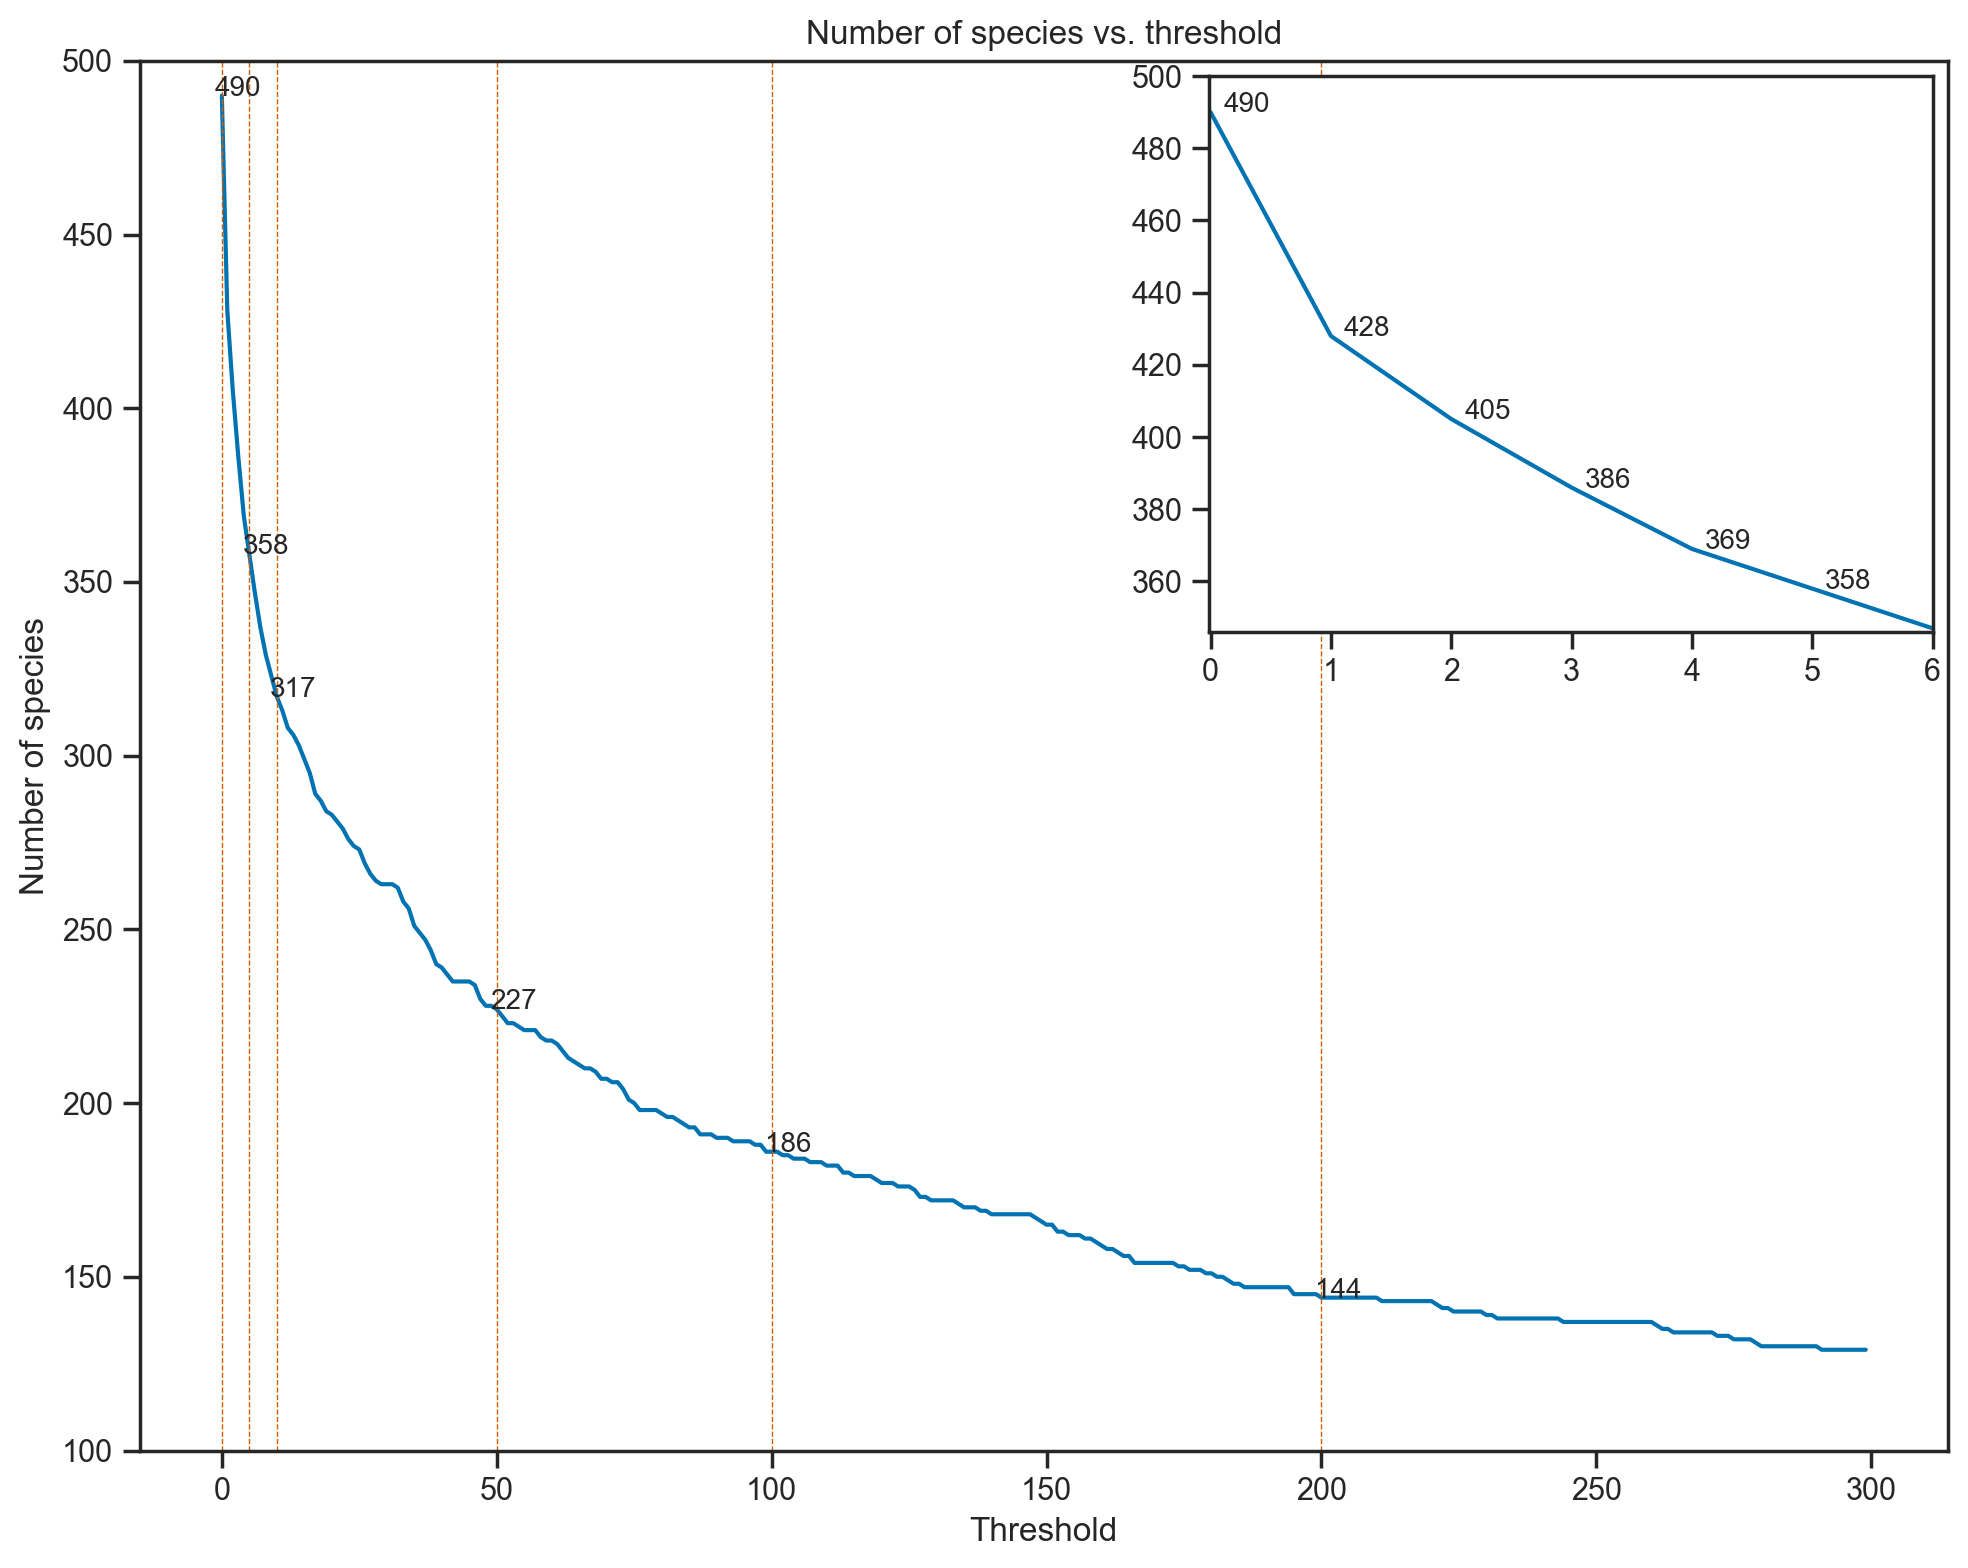

In [ ]:

# Create a plot of species count vs. threshold


# Thresholds are integers from 0 to 100 in steps of 5 and then from 100 to 200 in steps of 10 and then 200 to 1000 in steps of 1000 and then 1000 to 10000 in steps of 1000
thresholds = list(range(0, 101, 1)) + list(range(100, 300, 1)) #+ list(range(200, 1001, 100)) + list(range(1000, 10001, 1000))
species_counts = [len(ox_filter.get_species_list(threshold=t)) for t in thresholds]
# Plot the data using seaborn

fig, ax = plt.subplots(figsize=(10,8 ))

sns.lineplot(x=thresholds, y=species_counts,ax=ax)
# (Number of structures with the species in ICSD)"
plt.xlabel("Threshold"
           )
plt.ylabel("Number of species")
plt.title("Number of species vs. threshold")
# Annotate specific points
specific_thresholds = [0,5,10, 50, 100, 200]
for t in specific_thresholds:
    count = len(ox_filter.get_species_list(threshold=t))
    ax.annotate(f'{count}', xy=(t, count), xytext=(t+3, count),
                fontsize ="small",
                ha='center')
    ax.axvline(x=t, color='r', linestyle='--', lw=0.5)
    #ax.text(t-1, ax.get_ylim()[0]+50, f"t={t}", ha='center', va='top',fontsize="x-small", color='r',rotation=90)

ax.set_ylim(100,500)
# Add an inset figure to show a zoomed-in section for the threshold between 0 and 5
inset_ax = inset_axes(ax, width="40%", height="40%", loc='upper right')
zoom_thresholds = list(range(0, 7, 1))
zoom_species_counts = [len(ox_filter.get_species_list(threshold=t)) for t in zoom_thresholds]

sns.lineplot(x=zoom_thresholds, y=zoom_species_counts, ax=inset_ax)
for t in zoom_thresholds[:-1]:
    count = len(ox_filter.get_species_list(threshold=t))
    inset_ax.annotate(f'{count}', xy=(t, count), xytext=(t+0.3, count),
                fontsize ="small",
                ha='center')
inset_ax.set_xlim(-0.01, 6)
inset_ax.set_ylim(min(zoom_species_counts) - 1, max(zoom_species_counts) + 10)


plt.tight_layout()


plt.show()

From the above plot, we can see that the number of ionic species decreases as the threshold increases. Particularly, the inset plot shows that very small increments of the threshold can lead to large changes in the number of ionic species. This suggests that the choice of threshold is important when selecting the list of ionic species to use in SMACT workflows. This change occurs due to the presence of rare oxidation states in the ICSD.

/var/folders/rl/kjl1r2w97zs97xjkrgqz3lmh0000gp/T/ipykernel_83064/2663350812.py:15: FutureWarning:

We return_type='figure' over return_type='axes' for more consistent results.
This will become the default after 2025-07.



<Axes: title={'center': 'Number of oxidation states (threshold=100)'}>

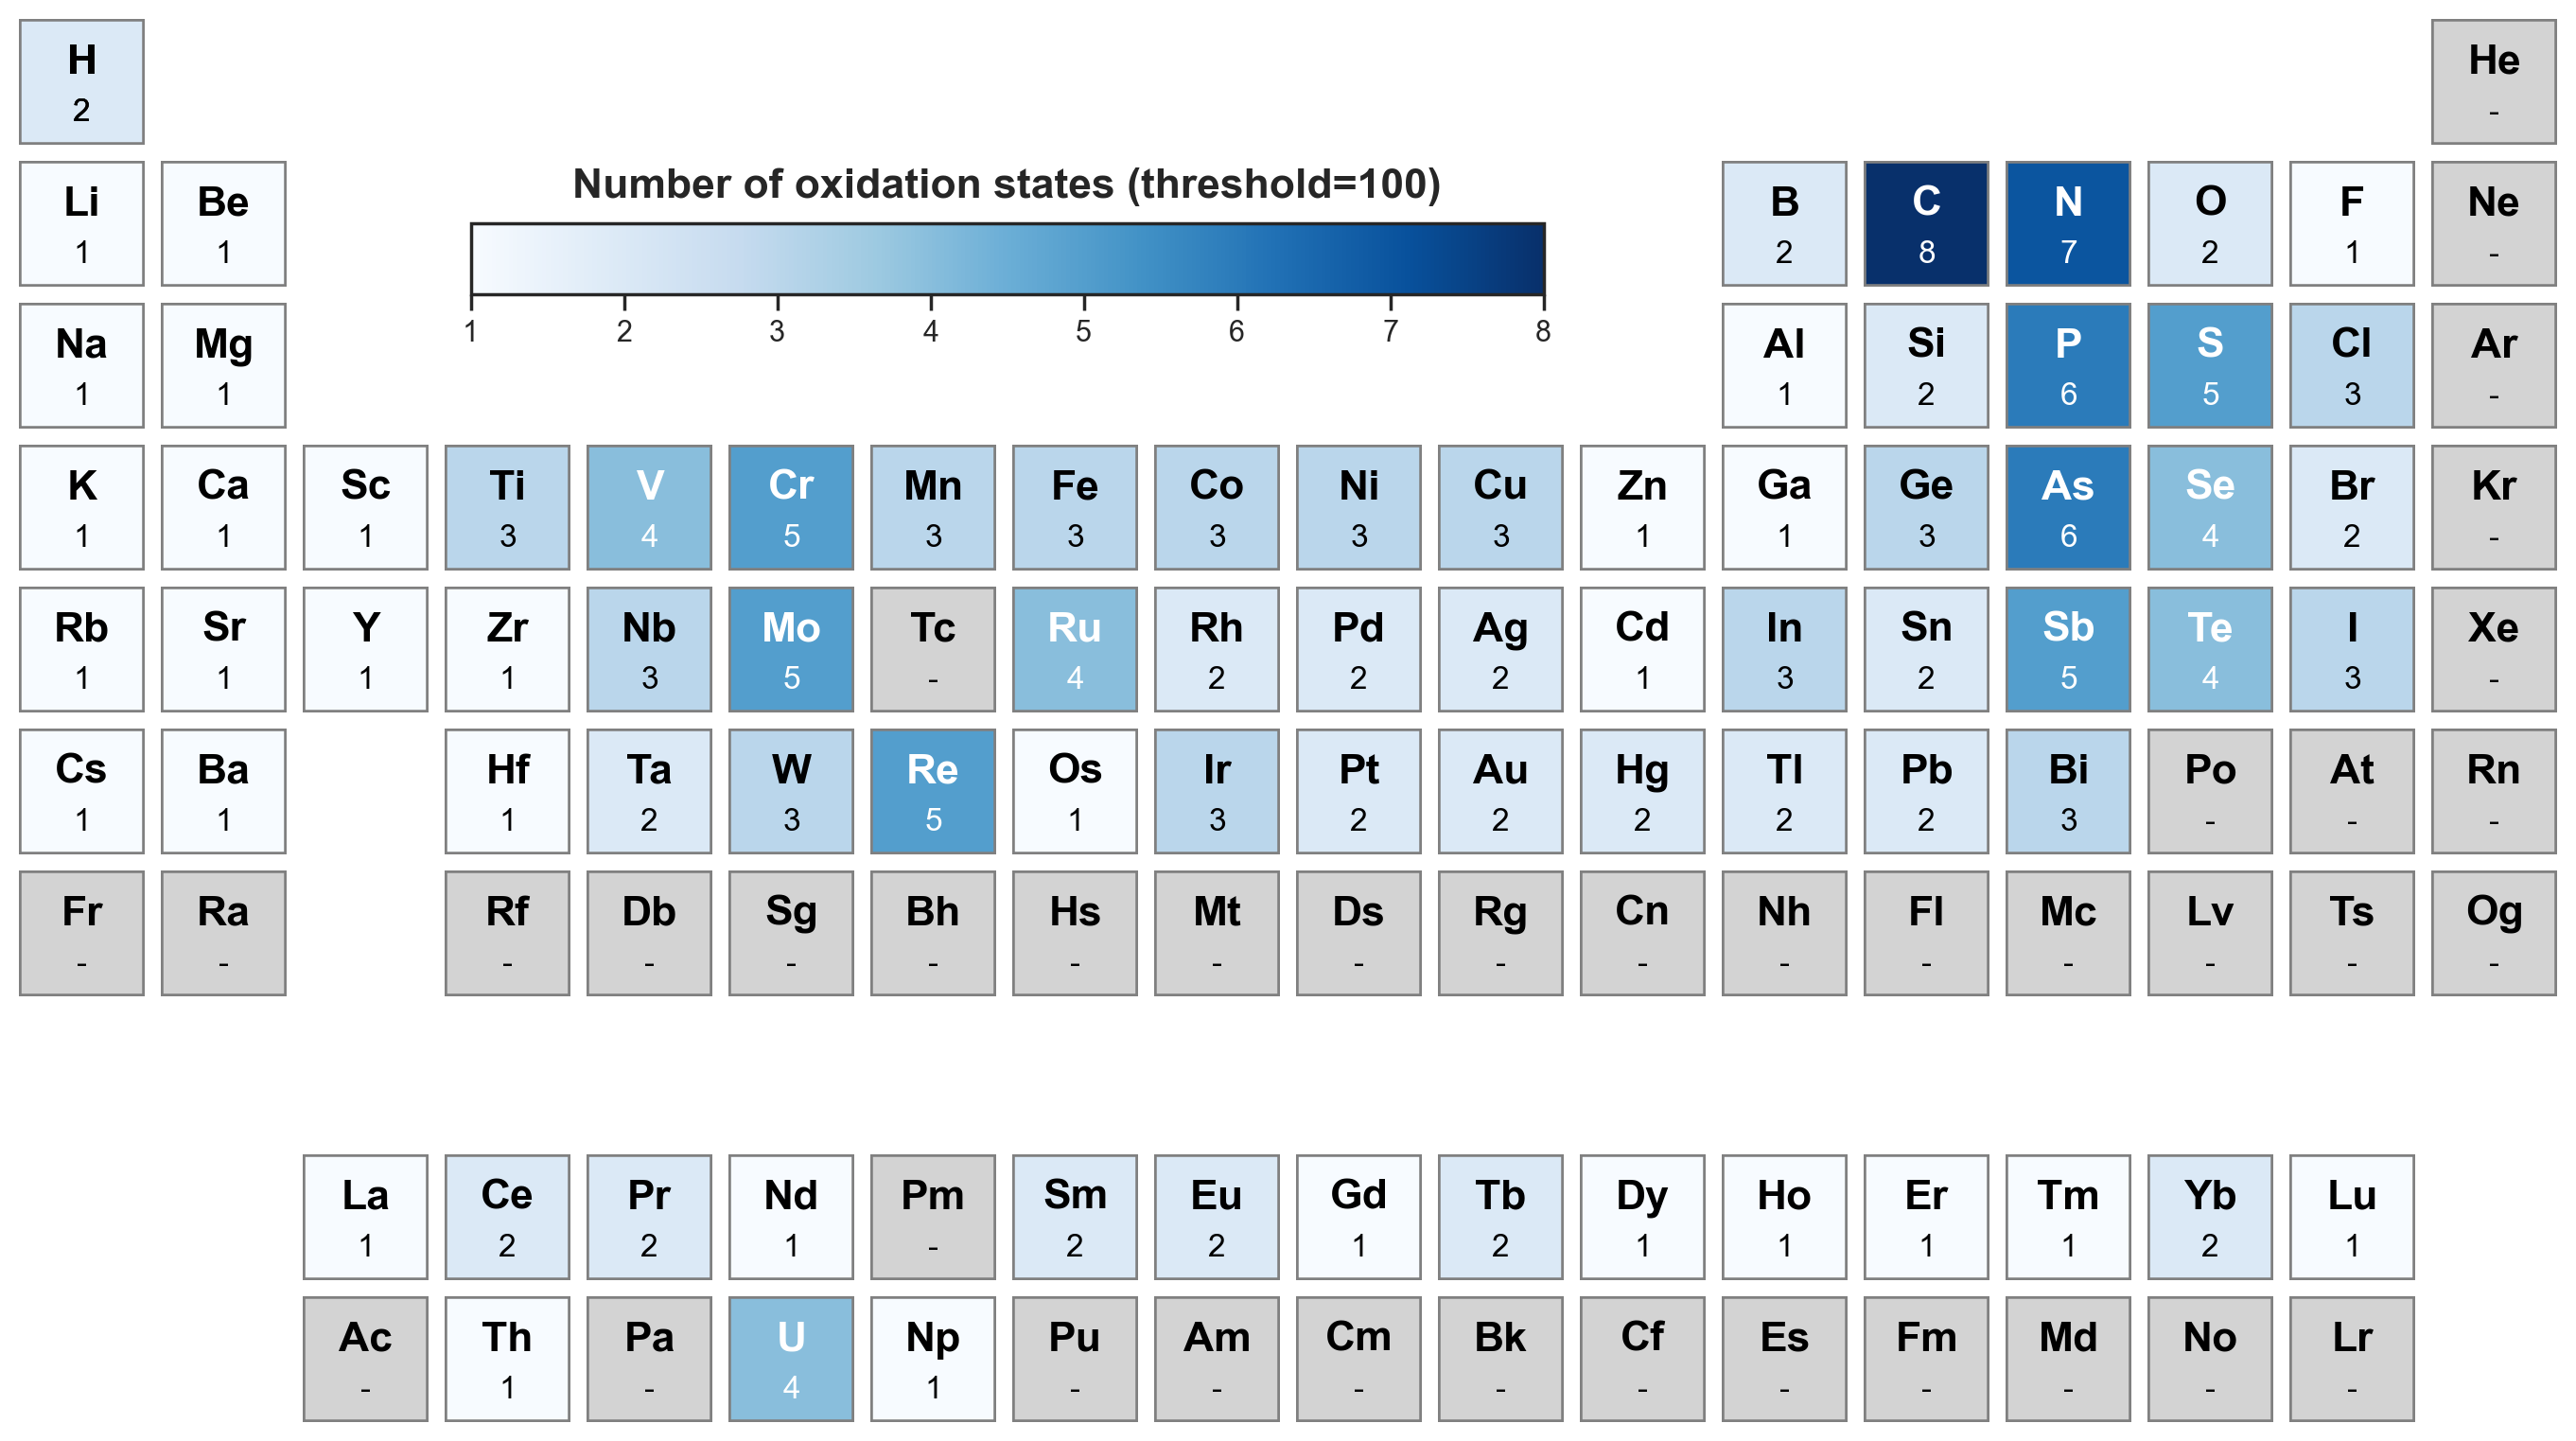

In [ ]:
# Visualise the counts of unique oxidation states for each element
# Get the list of species which occur in more than 100 structures in the ICSD
species_list_100 = ox_filter.get_species_list(threshold=100)

# Count the number of species for each element
element_counts = {}
for species in species_list_100:
    element, _ = parse_spec(species)
    if element in element_counts:
        element_counts[element] += 1
    else:
        element_counts[element] = 1

# Create a periodic table heatmap
pmv.ptable_heatmap(element_counts,
               cbar_title="Number of oxidation states (threshold=100)",
               colormap="Blues")


The above periodic table heatmap uses `pymatviz` with a `matplotlib` backend to show the number of unique oxidation states that each element has in the structures in the ICSD above the threshold. `pymatviz` also has a`plotly` backend which can be used to create interactive plots and enable more data to be displayed, via hovering over the elements.

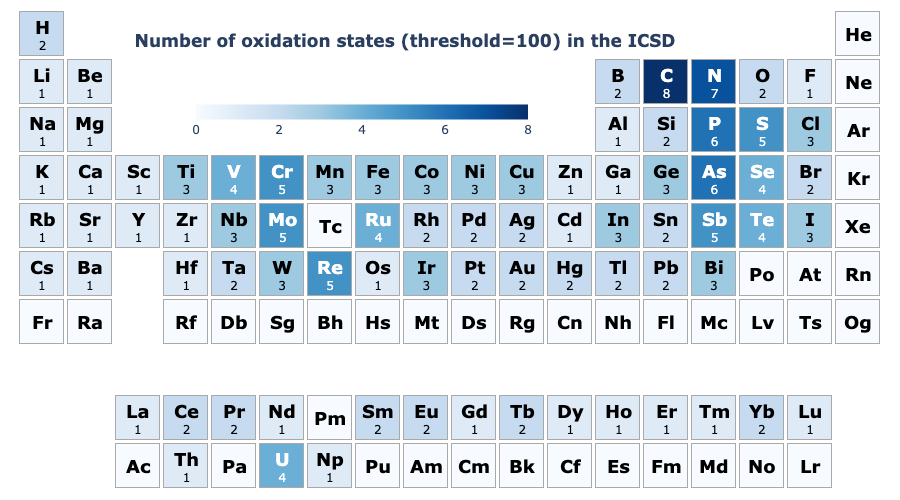

In [ ]:
# Create a dictionary of element symbol to oxidation state for the species in the list

oxidation_state_dict100 = ox_filter.filter(100).set_index("element")["oxidation_state"].apply(lambda x: f"Oxidation states: {x}").to_dict()

# Create a plotly heatmap
fig= pmv.ptable_heatmap_plotly(element_counts,
               fmt=".0f",
               colorscale="Blues",
               hover_data=oxidation_state_dict100,
               fill_value=0,
               )
title = (
    "<b>Number of oxidation states (threshold=100) in the ICSD</b>"
)
fig.layout.title = dict(text=title, x=0.45,y=0.93)
fig.show()


Using the plotly backend, we have included the oxidation states of each element as hover data.

### Dash app
We can go a bit further here and make a dash app to display the data in a more interactive way.

In [ ]:
thresholds_ = list(range(0, 101, 1)) + list(range(100, 300, 20)) + list(range(300, 1001, 100)) + list(range(1000, 10001, 1000))
threshold_figs = {}

for t in thresholds_:
    species_list_t = ox_filter.get_species_list(threshold=t)

    oxidation_state_dict_t = ox_filter.filter(t).set_index("element")["oxidation_state"].apply(lambda x: f"Oxidation states: {x}").to_dict()

    element_counts_t = {}
    for species in species_list_t:
        element, _ = parse_spec(species)
        if element in element_counts_t:
            element_counts_t[element] += 1
        else:
            element_counts_t[element] = 1

    fig = pmv.ptable_heatmap_plotly(element_counts_t,
                                    fmt=".0f",
                                    colorscale="Blues",
                                    hover_data=oxidation_state_dict_t,
                                    fill_value=0,
                                    cscale_range=(0,12)
                                    )
    title = (
        f"<b>Number of oxidation states (Threshold={t}) in the ICSD</b>"
    )
    fig.layout.title = dict(text=title, x=0.45,y=0.93)
    threshold_figs[t] = fig

In [ ]:
app = dash.Dash(prevent_initial_callbacks=True)

graph = dash.dcc.Graph(figure=fig, id="ptable-heatmap", responsive=True)
dropdown = dash.dcc.Dropdown(
    id="threshold-dropdown",
    options=[
        dict(label=threshold, value=threshold)
        for threshold in thresholds_
    ],
    style=dict(width="15em", position="absolute", top="0%", right="50%"),
    value=0,
    placeholder="Select threshold",
)
main_layout = dash.html.Div([graph, dropdown], style=dict(fontFamily="sans-serif"))
app.layout = main_layout


@app.callback(Output(graph.id, "figure"), Input(dropdown.id, "value"))
def update_figure(dropdown_value: str) -> go.Figure:
    """Update figure based on dropdown value."""
    return threshold_figs[dropdown_value]


app.run(debug=True, jupyter_mode="inline",jupyter_width="50%")

## Using custom Oxidation States in SMACT workflows

The oxidation states filter function can be used to create SMACT-compatible oxidation state lists which can be used with the `smact_validity` function for check if a compound passes the SMACT chemical rules or with the `smact_filter` function to enumerate "SMACT-sensible" compositions.

### SMACT Filter
We can enumerate SMACT-sensible compositions using the `smact_filter` function. Here, we will consider the `Zn-Ti-O` system and enumerate all possible compositions of Zn, Ti and O that pass the SMACT chemical rules. 

In [ ]:
# Define the elements for which we want to generate the allowed combinations
elements = ["Zn","Ti","O"]

# Create an element dictionary
space = smact.element_dictionary(elements)

# Enumerate the allowed combinations
allowed_combinations_smact14 = smact_filter(space.values(),threshold=8,oxidation_states_set="smact14")
allowed_combinations_icsd24_100 = smact_filter(space.values(),threshold=8,oxidation_states_set="oxidation_states_icsd24_100.txt")
allowed_combinations_icsd24 = smact_filter(space.values(),threshold=8,oxidation_states_set="icsd24")

# Convert to Pymatgen Composition objects
smact14_comps = list(set([comp_maker(c) for c in allowed_combinations_smact14]))
icsd24_100_comps = list(set([comp_maker(c) for c in allowed_combinations_icsd24_100]))
icsd24_comps = list(set([comp_maker(c) for c in allowed_combinations_icsd24]))

# Print the number of allowed combinations
print(f"Number of allowed combinations in the SMACT14 set: {len(allowed_combinations_smact14)}")
print(f"Number of allowed combinations in the ICSD24 (threshold=100) set: {len(allowed_combinations_icsd24_100)}")
print(f"Number of allowed combinations in the ICSD24 set: {len(allowed_combinations_icsd24)}")

Number of allowed combinations in the SMACT14 set: 170
Number of allowed combinations in the ICSD24 (threshold=100) set: 47
Number of allowed combinations in the ICSD24 set: 64


/Users/aoo216/miniforge3/envs/smact_dev/lib/python3.10/site-packages/matplotlib_venn/layout/venn3/pairwise.py:169: UserWarning:

Bad circle positioning.



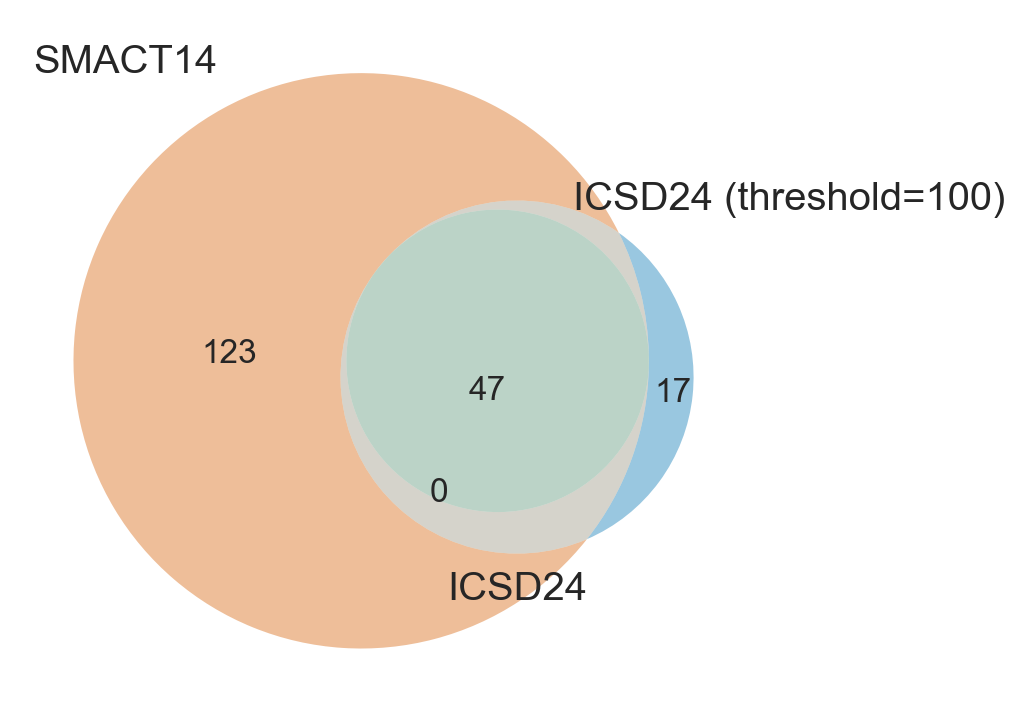

In [ ]:
# Create the unique sets to make venn diagrams

smact14_set = set(smact14_comps)
icsd24_100_set = set(icsd24_100_comps)
icsd24_set = set(icsd24_comps)

# Create the venn diagram

fig, ax = plt.subplots(figsize=(5, 5))

v=venn3((smact14_set, icsd24_100_set, icsd24_set), set_labels=("SMACT14", "ICSD24 (threshold=100)", "ICSD24"))

plt.show()

The Venn diagram provides a visual representation of the number of compositions that pass the SMACT filter using different sets of oxidation states.
As we can see, the number of compositions that pass the SMACT filter changes depending on the oxidation states used in the filter. This suggests that the choice of oxidation states is important when using the SMACT filter. Additionally, some oxidation state lists can result in unique compositions that would not be found using other oxidation state lists.

It is expected that the ICSD 24 list filtered for more than 100 occurrences would be a subset of the ICSD24 oxidation state list. Additionally, the threshold also reduces the possible compositions such that all of the enumerated compositions are a subset of the composition space enumerated using the 2014 SMACT oxidation state list.

In [ ]:
# Show the compositions unique to the ICSD24 set
pprint(icsd24_set - smact14_set)

{Composition('Zn3+:1 Ti4+:1 O-:7'),
 Composition('Zn3+:2 Ti4+:1 O2-:5'),
 Composition('Zn3+:4 Ti4+:1 O2-:8'),
 Composition('Zn3+:2 Ti4+:2 O2-:7'),
 Composition('Zn3+:1 Ti3+:1 O-:6'),
 Composition('Zn3+:1 Ti3+:1 O2-:3'),
 Composition('Zn3+:3 Ti3+:1 O2-:6'),
 Composition('Zn3+:1 Ti3+:3 O2-:6'),
 Composition('Zn3+:1 Ti2+:1 O-:5'),
 Composition('Zn3+:2 Ti2+:1 O-:8'),
 Composition('Zn3+:2 Ti2+:1 O2-:4'),
 Composition('Zn3+:4 Ti2+:1 O2-:7'),
 Composition('Zn3+:1 Ti2+:2 O-:7'),
 Composition('Zn3+:2 Ti2+:2 O2-:5'),
 Composition('Zn3+:2 Ti2+:3 O2-:6'),
 Composition('Zn3+:2 Ti2+:4 O2-:7'),
 Composition('Zn3+:2 Ti2+:5 O2-:8')}


We can see that from the list above, the unique compositions from using the ICSD 24 list all contain Zn<sup>3+</sup> which shows that it is not present in the manually compiled 2014 SMACT oxidation states list. Increasing the occurrence threshold to 100 eliminates the compositions conataining the Zn<sup>3+</sup> oxidation state, showing that while present in the ICSD, it is not a common oxidation state for Zn.

### SMACT Validity
We can check if a compound passes the SMACT chemical rules using the `smact_validity` function.

Note: This function is quite simple and as such currently fails for mixed valence compounds. This is something we are working on improving in the future.

In [ ]:


# Query the Materials Project API for all materials that have been experimentally synthesised
# You'll need to input your API key if it's not already set in the environment
with MPRester(use_document_model=False) as mpr:
    docs = mpr.materials.summary.search(theoretical=False,fields=["material_id","formula_pretty","energy_above_hull"])

# Create a dataframe from the results

mp_df = pd.DataFrame(docs)
mp_df.head(10)

Retrieving SummaryDoc documents:   0%|          | 0/48884 [00:00<?, ?it/s]

,formula_pretty,material_id,energy_above_hull
0,Ac,mp-10018,0.021639
1,Ac2O3,mp-11107,0.000000
2,AcBr3,mp-27972,0.000000
3,AcBrO,mp-30274,0.000000
4,AcCl3,mp-27971,0.000000
5,AcClO,mp-30273,0.000000
6,AcH2,mp-24147,0.000000
7,Ag,mp-10597,0.007669
8,Ag,mp-124,0.002127
9,Ag,mp-8566,0.000000


In [ ]:
# Sort the dataframe by formula_pretty and energy_above_hull and drop duplicate formula by keeping the lowest energy above hull
mp_df = mp_df.sort_values(["formula_pretty", "energy_above_hull"]).drop_duplicates("formula_pretty").reset_index(drop=True)
mp_df.head(10)

,formula_pretty,material_id,energy_above_hull
0,Ac,mp-10018,0.021639
1,Ac2O3,mp-11107,0.000000
2,AcBr3,mp-27972,0.000000
3,AcBrO,mp-30274,0.000000
4,AcCl3,mp-27971,0.000000
5,AcClO,mp-30273,0.000000
6,AcH2,mp-24147,0.000000
7,Ag,mp-8566,0.000000
8,Ag(AuF4)2,mp-18125,0.000000
9,Ag(BCl)6,mp-567334,0.000000


In [ ]:


supplied_oxidation_states = ["smact14","icsd24","icsd16","pymatgen_sp","oxidation_states_icsd24_100.txt"]

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
for ox_list in supplied_oxidation_states:
    mp_df[f"{ox_list}"] = mp_df["formula_pretty"].parallel_apply(lambda x: smact_validity(x, oxidation_states_set=ox_list))

mp_df.head(10)

,formula_pretty,material_id,energy_above_hull,smact14,icsd24,icsd16,pymatgen_sp,oxidation_states_icsd24_100.txt
0,Ac,mp-10018,0.021639,True,True,True,True,True
1,Ac2O3,mp-11107,0.000000,True,True,True,True,False
2,AcBr3,mp-27972,0.000000,True,True,True,True,False
3,AcBrO,mp-30274,0.000000,True,True,True,True,False
4,AcCl3,mp-27971,0.000000,True,True,True,True,False
5,AcClO,mp-30273,0.000000,True,True,True,True,False
6,AcH2,mp-24147,0.000000,True,False,False,False,False
7,Ag,mp-8566,0.000000,True,True,True,True,True
8,Ag(AuF4)2,mp-18125,0.000000,True,True,True,True,True
9,Ag(BCl)6,mp-567334,0.000000,False,False,False,False,False


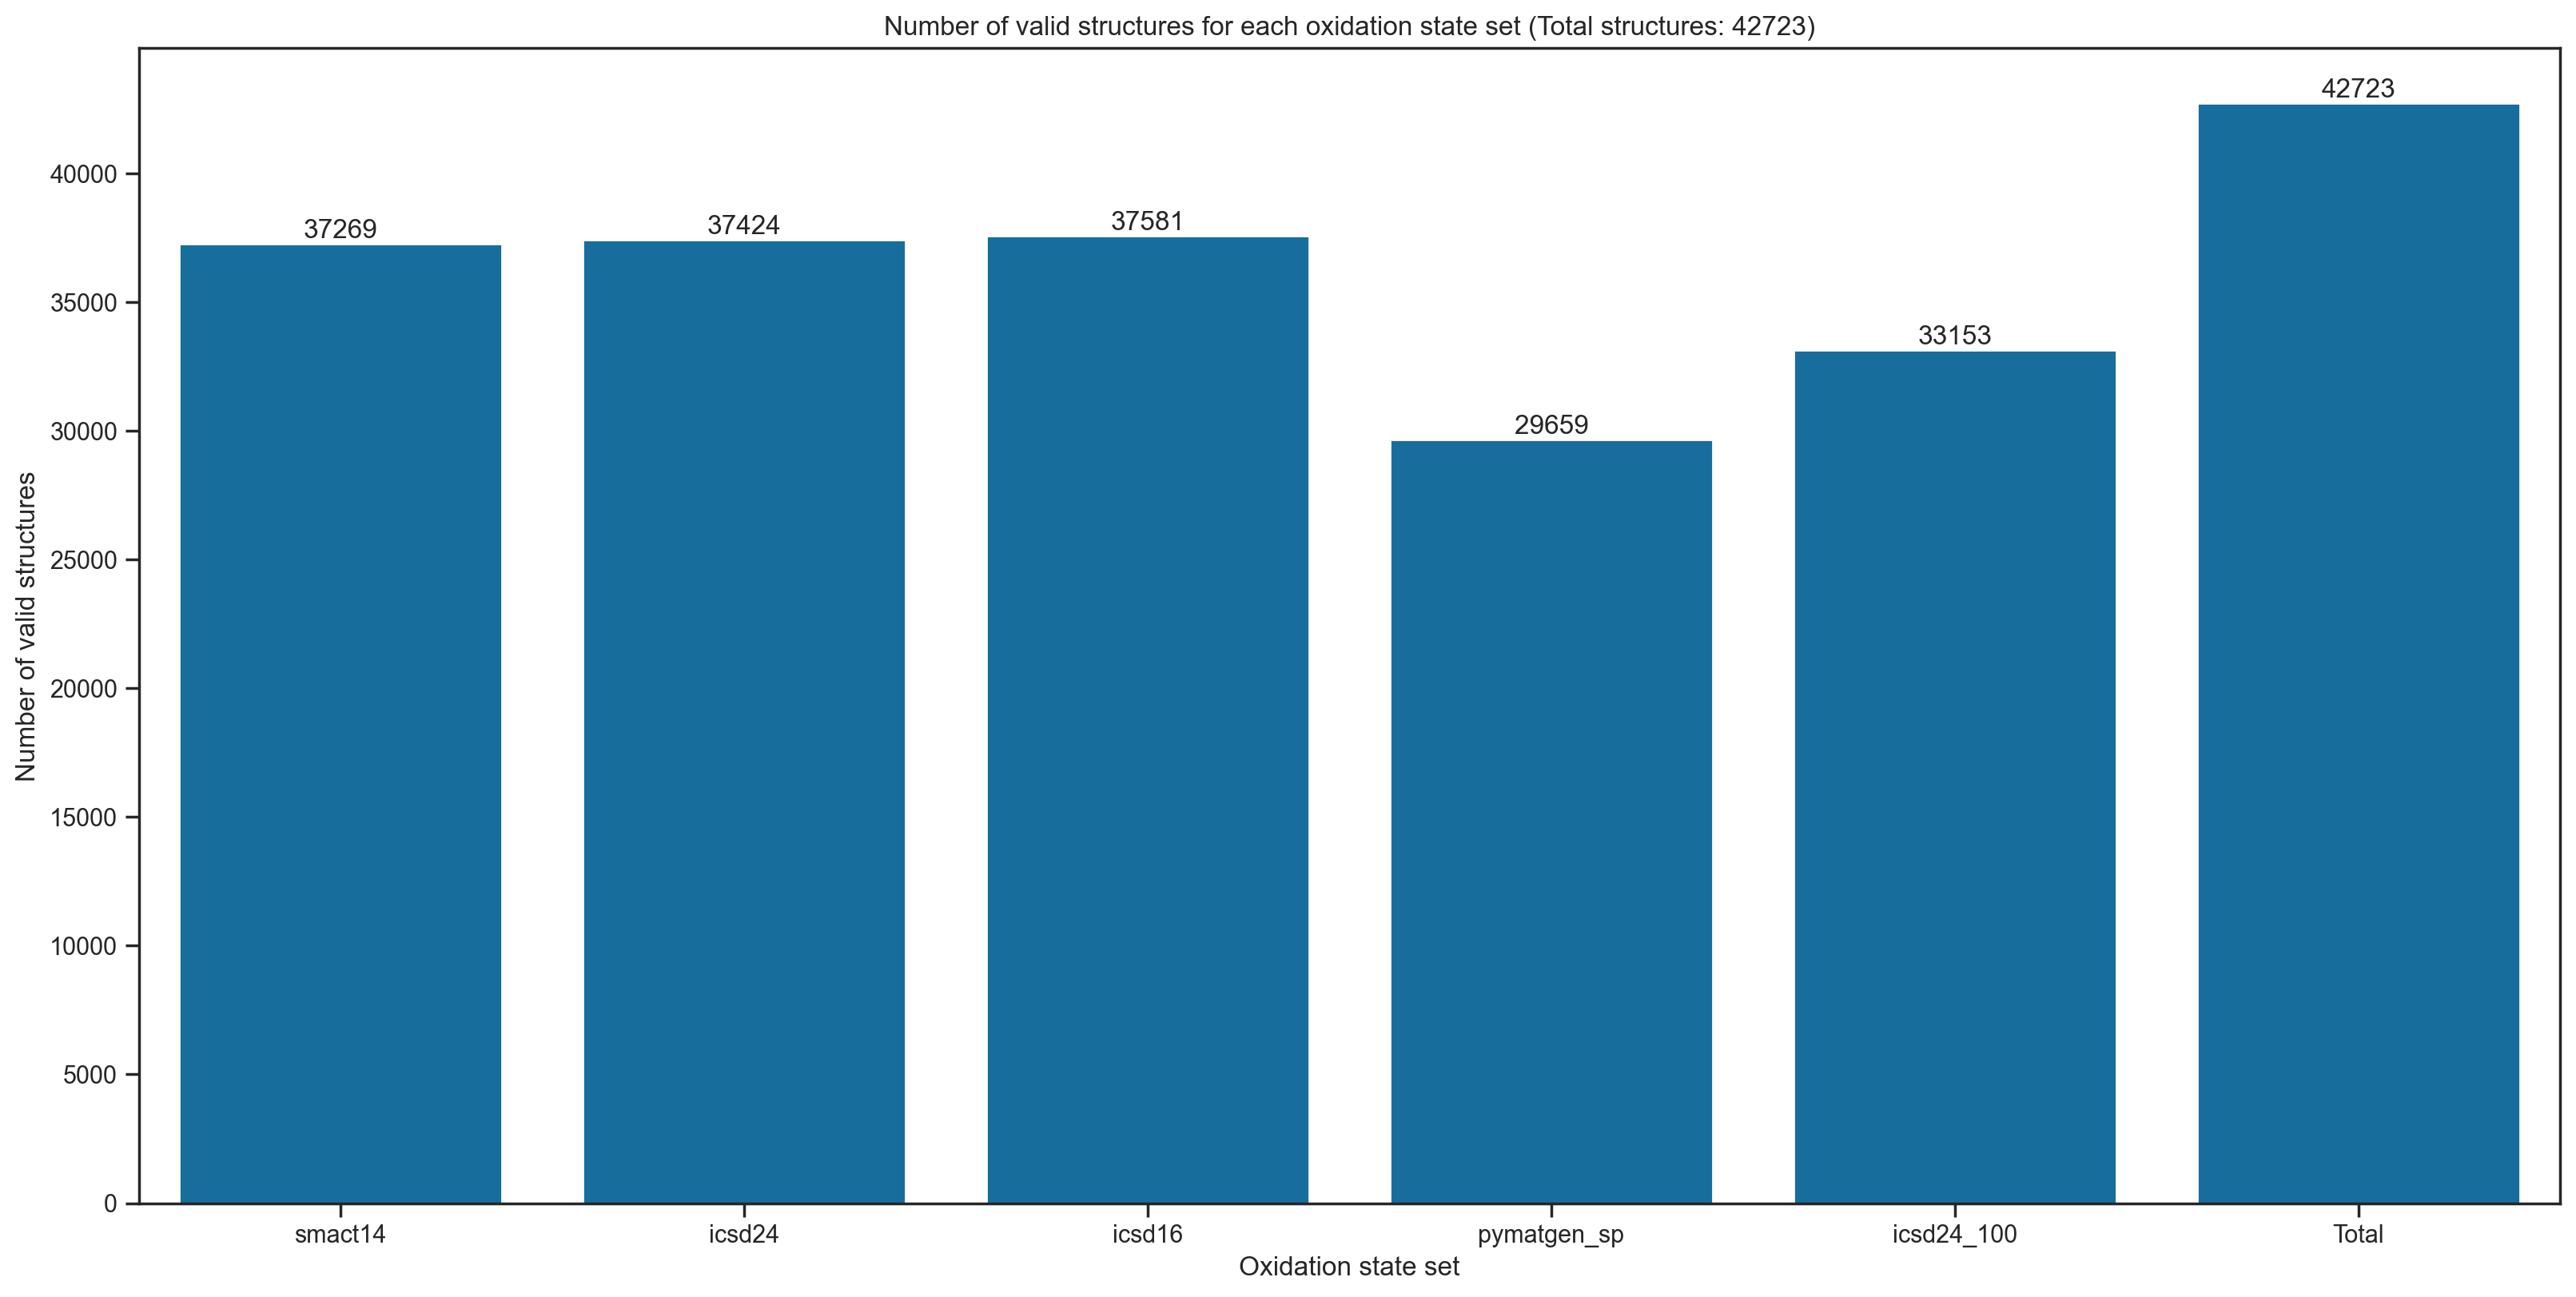

In [ ]:
# Plot the number of valid structures for each oxidation state set






valid_counts = mp_df[[f"{ox_list}" for ox_list in supplied_oxidation_states]].sum()
# Append the total number of structures to the valid_counts series
valid_counts = pd.concat([valid_counts,pd.Series([len(mp_df)], index=["Total"])])
# Relabel the index oxidation_states_icsd24_100.txt to icsd24_100
valid_counts.rename(index={"oxidation_states_icsd24_100.txt":"icsd24_100"}, inplace=True)
fig, ax = plt.subplots(figsize=(16,8))
# Show the numbers on the bars
for i, v in enumerate(valid_counts.values):
    ax.text(i, v + 10, str(v), ha='center', va='bottom')
sns.barplot(x=valid_counts.index, y=valid_counts.values, ax=ax)
ax.set_xlabel("Oxidation state set")
ax.set_ylabel("Number of valid structures")

#
# Include total number of structures in the title

total_structures = len(mp_df)
ax.set_title(f"Number of valid structures for each oxidation state set (Total structures: {total_structures})")
plt.show()